<img width="100" src="https://carbonplan-assets.s3.amazonaws.com/monogram/dark-small.png" style="margin-left:0px;margin-top:20px"/>

# Forest Emissions Tracking - Validation

_CarbonPlan ClimateTrace Team_

This notebook compares our estimates of country-level forest emissions to prior
estimates from other groups. The notebook currently compares againsts:

- Global Forest Watch (Zarin et al. 2016)
- Global Carbon Project (Friedlingstein et al. 2020)


In [1]:
import geopandas
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt

from carbonplan_styles.mpl import set_theme

set_theme()

## Loading data 

In [13]:
# Input data
# ----------

# country shapes from GADM36
countries = geopandas.read_file(
    "s3://carbonplan-climatetrace/inputs/shapes/countries.shp"
)

# CarbonPlan's emissions
emissions = {}
versions = ["v0.3"]
for version in versions:
    for mechanism in ["fire", "clearing"]:
        emissions[version + "-" + mechanism] = pd.read_csv(
            "s3://carbonplan-climatetrace/{}/country_rollups_emissions_from_{}.csv".format(
                version, mechanism
            )
        )
    emissions[version] = emissions[version + "-fire"].copy(deep=True)
    emissions[version]["tCO2eq"] = (
        emissions[version + "-fire"]["tCO2eq"]
        + emissions[version + "-clearing"]["tCO2eq"]
    )

# Blue Sky Fire emissions
emissions["Blue Sky"] = pd.read_csv(
    "s3://carbonplan-climatetrace/validation/forest-fires_bsa.csv"
)

bsa = pd.read_csv('global-CO2-estimates-per-vegetation-2015-2020-BSA.csv')
opencanopy = bsa[bsa['parent_class']=='open_canopy_forest'].drop('parent_class', axis=1)
closedcanopy = bsa[bsa['parent_class']=='closed_canopy_forest'].drop('parent_class', axis=1)
merged = pd.merge(opencanopy.rename({'tCO2': 'open_canopy'}, axis=1), 
         closedcanopy.rename({'tCO2': 'closed_canopy'}, axis=1),
         how='left', left_on=['iso3_country','begin_date', 'end_date'],
         right_on=['iso3_country','begin_date', 'end_date'])
merged['tCO2'] = merged.closed_canopy.fillna(0) + merged.open_canopy.fillna(0)
emissions["Blue Sky Slack"] = merged[['iso3_country', 'begin_date', 'end_date', 'tCO2']]

In [14]:
version = 'v0.3'

comparison = pd.merge(
    emissions[f"{version}-fire"].rename({"tCO2eq": "CarbonPlan"}, axis=1),
    emissions["Blue Sky"].rename({"tCO2": "Blue Sky Website"}, axis=1),
    how="inner", #"left",
    left_on=["iso3_country", "begin_date", "end_date"],
    right_on=["iso3_country", "begin_date", "end_date"],
).merge(
    emissions[version].rename({"tCO2eq": "CarbonPlan Total"}, axis=1),
    how="inner", #"left",
    left_on=["iso3_country", "begin_date", "end_date"],
    right_on=["iso3_country", "begin_date", "end_date"],
).merge(
    emissions['Blue Sky Slack'].rename({"tCO2": "Blue Sky Slack"}, axis=1),
    how="inner", #"left",
    left_on=["iso3_country", "begin_date", "end_date"],
    right_on=["iso3_country", "begin_date", "end_date"],
)

comparison["Blue Sky Slack"] /= 1e9
comparison["Blue Sky Website"] /= 1e9

comparison['year'] = pd.to_datetime(comparison.begin_date).dt.year

## Comparison 


In [17]:
import altair as alt

In [18]:
blue_sky_channel = 'Slack'

In [19]:
chart = alt.Chart(comparison).mark_circle(size=60).encode(
    x="CarbonPlan",
    y=f"Blue Sky {blue_sky_channel}",
    color='year:N',
    tooltip=['iso3_country', 'year', 'CarbonPlan', f"Blue Sky {blue_sky_channel}"]
).interactive()

line = pd.DataFrame({
    'CarbonPlan': [0, 1],
    f"Blue Sky {blue_sky_channel}":  [0, 1],
})

line_plot = alt.Chart(line).mark_line(color='k').encode(
    x= 'CarbonPlan',
    y= f"Blue Sky {blue_sky_channel}",
)

(chart + line_plot)

alt.LayerChart(...)

In [28]:
comparison.groupby('year')[['CarbonPlan', f"Blue Sky {blue_sky_channel}"]].sum()

,CarbonPlan,Blue Sky Slack
year,,
2015,2.030609,5.084798
2016,2.584718,4.808536
2017,2.607886,4.820343
2018,2.019685,4.742444
2019,2.455547,5.786894
2020,2.704337,5.735276


In [27]:
country_agg = comparison.groupby('iso3_country')[['CarbonPlan', f"Blue Sky {blue_sky_channel}", 'CarbonPlan Total']].sum()
(country_agg[f"Blue Sky {blue_sky_channel}"] > country_agg['CarbonPlan Total']).mean()

0.33170731707317075

In [22]:
country_agg.loc[(country_agg[f"Blue Sky {blue_sky_channel}"] > country_agg['CarbonPlan Total'])].sort_values(by=f"Blue Sky {blue_sky_channel}", ascending=False)

,CarbonPlan,Blue Sky Slack,CarbonPlan Total
iso3_country,,,
AGO,0.199630,2.369244e+00,5.582576e-01
AUS,0.656183,2.089056e+00,1.974687e+00
MOZ,0.232784,1.304020e+00,6.493433e-01
ZMB,0.170092,1.289586e+00,4.883250e-01
CAF,0.047263,1.232160e+00,1.498154e-01
...,...,...,...
BLM,0.000000,2.650902e-07,1.160499e-08
ABW,0.000000,9.179722e-08,1.384370e-10
JEY,0.000000,4.189250e-08,1.110972e-08


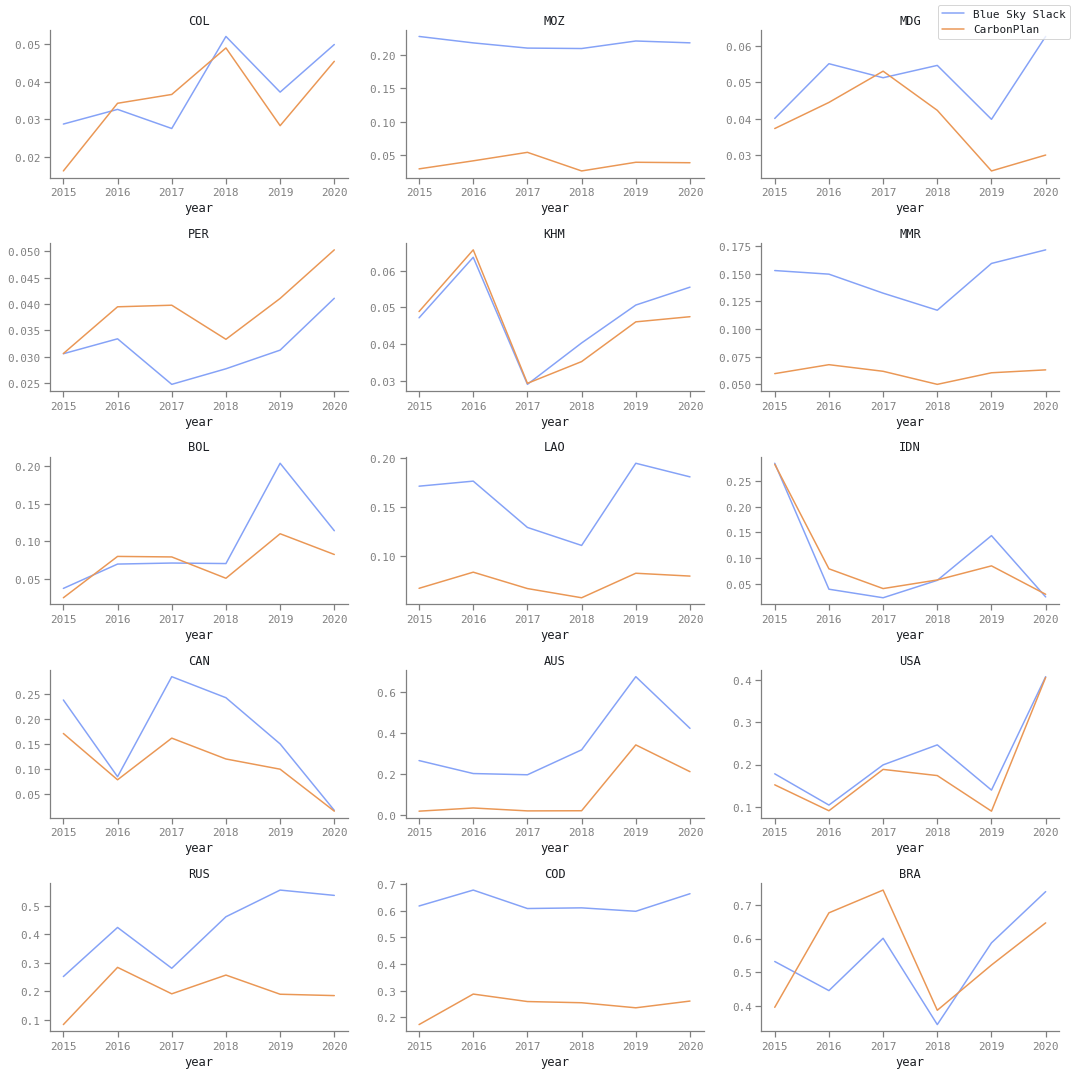

In [31]:
top_emitters = comparison.groupby('iso3_country').sum().sort_values(by='CarbonPlan').tail(15).index.values
top_emitters_df = comparison.loc[comparison.iso3_country.isin(top_emitters)]

plt.figure(figsize=(15, 15))
for i, country in enumerate(top_emitters):
    plt.subplot(5,3,i+1)
    sub = top_emitters_df.loc[top_emitters_df.iso3_country == country]
    sub.plot.line(x='year', y=f"Blue Sky {blue_sky_channel}", ax=plt.gca(), legend=False)
    sub.plot.line(x='year', y='CarbonPlan', ax=plt.gca(), legend=False)
#     sub.plot.line(x='year', y='CarbonPlan Total', ax=plt.gca(), legend=False)
    plt.title(country)
handles, labels = plt.gca().get_legend_handles_labels()
plt.gcf().legend(handles, labels, loc='upper right')
plt.tight_layout()

plt.savefig('comparison_top_emitters_total.png')
plt.show()
plt.close()



In [24]:
with_geometry = countries.merge(
    comparison.groupby(['iso3_country', 'begin_date', 'year']).mean().reset_index().rename(columns={"iso3_country": "alpha3"}),
    on="alpha3",
)

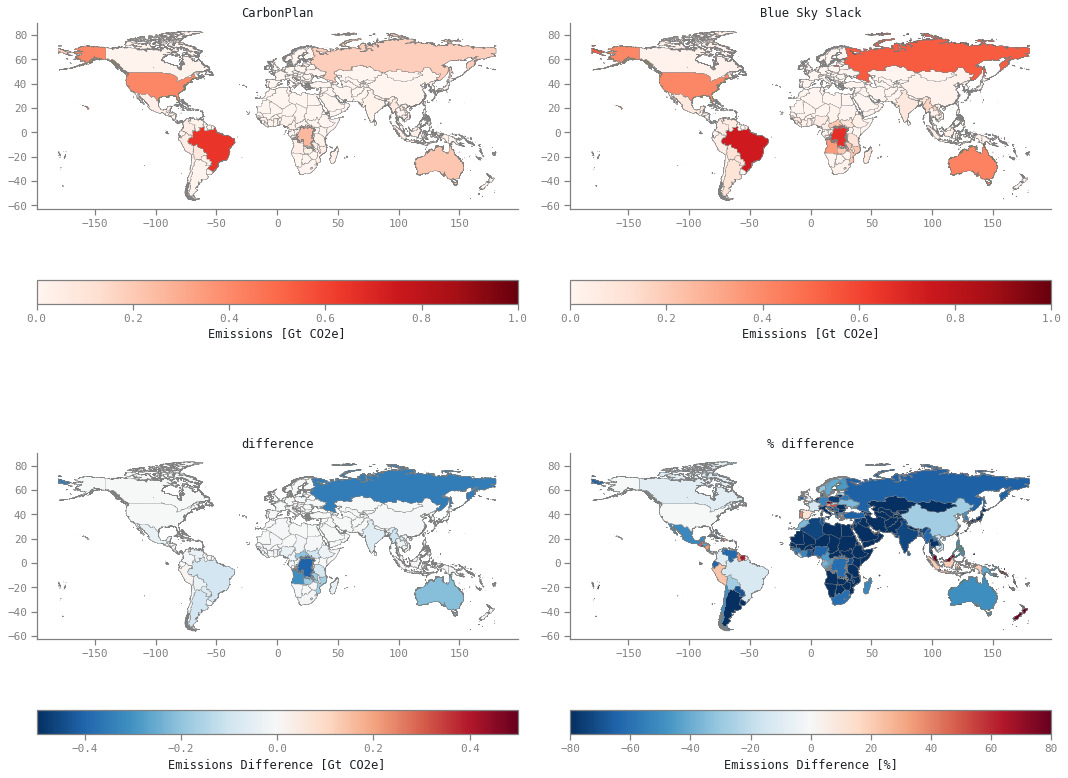

In [25]:
fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=(15, 13))
for i, name in enumerate(['CarbonPlan', f"Blue Sky {blue_sky_channel}"]):
    kwargs = dict(
        legend=True,
        legend_kwds={
            "orientation": "horizontal",
            "label": "Emissions [Gt CO2e]",
        },
        lw=0.25,
        cmap="Reds",
        vmin=0,
        vmax=1,
        ax=axarr[0, i],
    )
    with_geometry.plot(name, **kwargs)
    axarr[0, i].set_title(name)

    
kwargs = dict(
    legend=True,
    legend_kwds={
        "orientation": "horizontal",
        "label": "Emissions Difference [Gt CO2e]",
    },
    lw=0.25,
    cmap="RdBu_r",
    vmin=-0.5,
    vmax=0.5,
    ax=axarr[1, 0],
)
with_geometry["diff"] = (
    with_geometry["CarbonPlan"]
    - with_geometry[f"Blue Sky {blue_sky_channel}"]
)
with_geometry.plot("diff", **kwargs)
axarr[1, 0].set_title("difference")

    
kwargs = dict(
    legend=True,
    legend_kwds={
        "orientation": "horizontal",
        "label": "Emissions Difference [%]",
    },
    lw=0.25,
    cmap="RdBu_r",
    vmin=-80,
    vmax=80,
    ax=axarr[1, 1],
)
with_geometry["pdiff"] = (
    (
        with_geometry["CarbonPlan"]
        - with_geometry[f"Blue Sky {blue_sky_channel}"]
    )
    / with_geometry[f"Blue Sky {blue_sky_channel}"]
) * 100
with_geometry.plot("pdiff", **kwargs)
axarr[1, 1].set_title("% difference")

plt.tight_layout()
plt.savefig('comparison_map.png')

## Causes 

### Fire Definition 

In [41]:
from carbonplan_trace.v0.data.load import open_hansen_change_tile
from carbonplan_trace.v0.workflow import open_fire_mask
import xarray as xr

In [68]:

def get_fire_da(tile_id, years):
    return open_fire_mask(tile_id, y0=years[0], y1=years[1])


def get_change_da(tile_id, years):
    lat, lon = tile_id.split('_')
    change_ds = open_hansen_change_tile(lat, lon)[['lossyear']]
    yrs = xr.DataArray(np.arange(years[0], years[1] + 1), dims=("year",), name="year")
    change_da = xr.concat(
        [xr.where((change_ds["lossyear"] == yr), 1.0, 0.0) for yr in yrs], dim=yrs
    )
    
    return change_da

In [63]:
import carbonplan_trace.v1.utils as utils

min_lat = -90
max_lat = 90
min_lon = -180
max_lon = 180

tiles = utils.find_tiles_for_bounding_box(
    min_lat=min_lat, max_lat=max_lat, min_lon=min_lon, max_lon=max_lon
)

In [69]:
years = (2015, 2020)

results = {}
for tile_id in tiles:
    fire_da = get_fire_da(tile_id, years)
    change_da = get_change_da(tile_id, years)
    
    fire_frac = fire_da.mean().values
    change_frac = change_da.mean().values
    results[tile_id] = [fire_frac, change_frac]

KeyboardInterrupt: 

In [70]:
df = pd.DataFrame.from_dict(results, orient='index', columns=['fire fraction', 'forest lost fraction'])

In [77]:
df.sum()

fire fraction           2.109035
forest lost fraction    0.095083
dtype: object

In [78]:
len(df)

75

### Emission factors 

In [36]:
import numpy as np

np.mean(
    [.205 , .235 , .563 , .275 , .403 , 
     .292 , .201 , .295 , .437 , .275 , 
     .200 , .456 , .226 , .241 , .392 , 
     .239 , .420 , .322
    ]
)

0.3153888888888889

In [ ]:
comparison['difference'] = comparison["CarbonPlan"] - comparison["Blue Sky"]
comparison['abs difference'] = comparison['difference'].abs()
comparison['% difference'] = comparison['difference'] / comparison["Blue Sky"]